# Titanic数据分析报告(2017.11.19修改版)

## 1.数据理解

数据来自于名为“titanic-data.csv”的文件，包含了关于Titanic号邮轮上面891名乘客的信息。根据 [这个链接](http://www.sohu.com/a/152335921_464026)     理解到里面一些生僻字段的含义，包括：sibsp:有多少兄弟姐妹/配偶在船上，parch:有多少父母/孩子在船上，embarked： 启航港口：C = Cherbourg, Q = Queenstown, S = Southampton。

通过pandas将文件读入，下面展示了前3条记录内容：

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

titanic_df = pd.read_csv('titanic-data-1.csv')         # 数据文件已更改为正确版本:)
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


可见每一行数据记录了一位乘客的信息，包括姓名、年龄、性别、是否幸存、船舱号、票价等等信息。

## 2.数据探索

分析数据之前我们先观察数据的完整性：

In [2]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB


可以看到，'Age'字段、'Cabin'字段还有'Embarked'字段存在着不同程度的缺失，在后面数据处理时需要留意。

通过以下代码查看891名乘客中男女乘客各占多少：

In [4]:
titanic_df['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

结果显示男性乘客577名，女性乘客314名。

我们想了解男女乘客的年龄分布情况，使用以下代码：

In [5]:
titanic_df.groupby('Sex').describe()['Age']

Sex          
female  count    261.000000
        mean      27.915709
        std       14.110146
        min        0.750000
        25%       18.000000
        50%       27.000000
        75%       37.000000
        max       63.000000
male    count    453.000000
        mean      30.726645
        std       14.678201
        min        0.420000
        25%       21.000000
        50%       29.000000
        75%       39.000000
        max       80.000000
Name: Age, dtype: float64

由上可看出，男女乘客平均年龄差距不是很大（男：30.73岁，女：27.92岁），标准差也相仿（男：14.68岁，女：14.11岁），年龄分布大体相近。同时需要注意到，男女乘客信息中，带有'Age'这一字段内容的人数为261 + 453 = 714，不等于总人数891，说明数据中部分乘客年龄不详，这一点可以理解。

下面的代码给出男女乘客各自的年龄直方分布图：

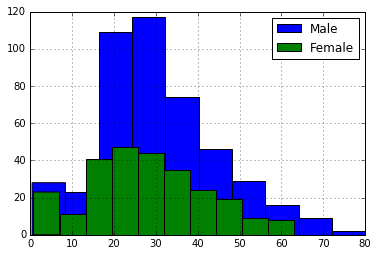

In [6]:
male_records = titanic_df[titanic_df['Sex'] == 'male']
female_records = titanic_df[titanic_df['Sex'] == 'female']

male_records['Age'].hist()
female_records['Age'].hist()
plt.legend(['Male', 'Female'])

上图中蓝色为男性乘客，绿色为女性乘客。可以看到分布形状基本吻合，与上文分析结果相符。

下面我想了解乘客们的舱室等级分布情况，使用以下代码：

In [7]:
#titanic_df.groupby(['Pclass']).count()['PassengerId']
titanic_df.groupby(['Pclass'])['PassengerId'].count()

Pclass
1    216
2    184
3    491
Name: PassengerId, dtype: int64

由于PassengerId都不为0，所以按该字段统计求和结果就等于各舱室等级乘客数。结果显示，Titanic号上一等舱乘客216人，二等舱乘客184人，三等舱乘客491人，结果与我们设想稍微有点不一致，因为一般情况下，一二三等舱乘客数应该依次递增，我们试着分析下原因**(问题1)**。

在电影《Titanic》里面，我们看到过这样的镜头：有钱人们聚集在甲板上拥挤着争抢所剩不多的救生艇空位，而低等级船舱里的乘客被铁链锁住了通往甲板的通道，只能相拥着等待死神的降临，贪生怕死是这些富人们的真实写照；当然，也有站出来为片中的有钱人们鸣怨的，根据这篇小鸡汤 [大力猛击我](http://www.360doc.com/content/14/0424/22/1130227_371847207.shtml) 里描述，当灾难降临之际，大多数绅士都选择将生的机会留给儿童、妇女和老人，留下自己勇敢面对灾难。那么这些说法谁真谁假？我们的数据能否揭开事实的真相？**（问题2）**

数据中还包含了一个叫做“启航港口”的字段，我猜测这是乘客登船的港口名称，也就是说船上乘客分别在三个港口登船。我们试着分析下各个港口上船的乘客特征**（问题3）**。

## 3.问题分析

### 1) 问题1:各客舱等级乘客分布

实际上可能是因为，这份数据并未包含全部的乘客名单。根据 [这个链接](https://zhidao.baidu.com/question/355010484.html?qbl=relate_question_1) 显示，Titanic号总共有1500余人丧生，还有700余人获救，而我们的记录总共只包含了不到900人，所以当样本数目不足够时，统计结果可能会有偏差。

还有一种可能性，那就是这份报告统计有误。记录里面包含了船票价格信息，我们尝试能否从中寻找答案。我们执行以下代码，得到三个等级舱室票价的分布与箱线图：

In [8]:
#class_1_records = titanic_df[titanic_df['Pclass'] == 1]
#class_2_records = titanic_df[titanic_df['Pclass'] == 2]
#class_3_records = titanic_df[titanic_df['Pclass'] == 3]

#print("Class 1")
#class_1_records['Fare'].describe()

titanic_df.groupby(['Pclass'])['Fare'].describe()

Pclass       
1       count    216.000000
        mean      84.154687
        std       78.380373
        min        0.000000
        25%       30.923950
        50%       60.287500
        75%       93.500000
        max      512.329200
2       count    184.000000
        mean      20.662183
        std       13.417399
        min        0.000000
        25%       13.000000
        50%       14.250000
        75%       26.000000
        max       73.500000
3       count    491.000000
        mean      13.675550
        std       11.778142
        min        0.000000
        25%        7.750000
        50%        8.050000
        75%       15.500000
        max       69.550000
dtype: float64

可以看到，三个舱室都有票价是0的……**这说明这份数据关于票价方面存在一定问题。**

下面分析一下各等级舱室票价分布情况：

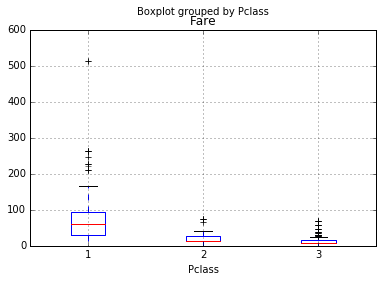

In [9]:
#passengers_by_class_records = pd.DataFrame([class_1_records['Fare'].values, class_2_records['Fare'].values, 
#                                                class_3_records['Fare'].values], index = ['Class 1', 'Class 2', 'Class 3'])

#passengers_by_class_records_T = passengers_by_class_records.T

#plt.figure(figsize=(10,6))
#ax = passengers_by_class_records_T.boxplot()


titanic_df.boxplot(column = 'Fare', by = 'Pclass')


从箱线图可以看到，同样是头等舱，价格相差悬殊，最高价格超过500（英镑？），而中位数水平只有大约60(英镑)左右；同样二等舱也有类似现象，不过“异常值”与“正常值”相差没有那么大；三等舱的票价分布与二等舱类似，最高约70（英镑），也存在部分异常点。

据此，我们应该可以判定：
1）票价数据存在部分问题：各舱室都存在票价为0的情况，个人推测这些错误值来自人工统计错误，或者是统计者对查不到的信息通过补0的方式来处理造成的；
2）排除0值的情况，各等级舱室票价分布基本符合预期，一等最高，然后依次是二等和三等，从票价上看不出明显的问题；

通过互联网我们寻找到了答案：[点我](https://zhidao.baidu.com/question/391569782), 原来人家就是这样设计的~

### 2) 问题2:谁死谁生

我们假设各等级船舱人数的统计结果是正确的，那么在这891名乘客中，各等级船舱乘客死亡率通过下列代码获得：

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: PassengerId, dtype: int64


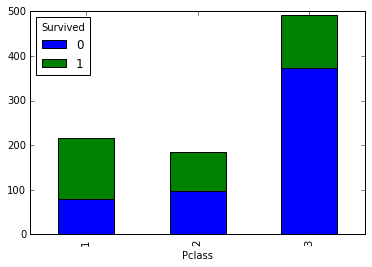

In [10]:
#def get_death_info(records):
#    '''
#    从各等级舱室乘客信息中提取死亡人数与死亡率
#    records：各等级舱室乘客信息；
#    return：死亡人数，死亡率
#    '''
#    death_count = records['Survived'].value_counts()[0]
#    count = records.iloc[:, 0].size
#    death_rate = death_count / float(count)
    
#    return (death_count, death_rate)


# 获取死亡人数与死亡率
#class_1_count, class_1_death_rate = get_death_info(class_1_records)
#class_2_count, class_2_death_rate = get_death_info(class_2_records)
#class_3_count, class_3_death_rate = get_death_info(class_3_records)


# 打印结果
#print('Class 1 death count: %d') % class_1_death_count
#print('Class 1 death rate: %f\n') % class_1_death_rate

#print('Class 2 death count: %d') % class_2_death_count
#print('Class 2 death rate: %f\n') % class_2_death_rate

#print('Class 3 death count: %d') % class_3_death_count
#print('Class 3 death rate: %f\n') % class_3_death_rate


# 获得各等级乘客生还与死亡人数
print(titanic_df.groupby(['Pclass', 'Survived'])['PassengerId'].count())


# 画出各等级舱室死亡与幸存人数对比图
titanic_df.groupby(['Pclass', 'Survived'])['Survived'].count().unstack().plot(kind = 'bar', stacked = 'True')

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


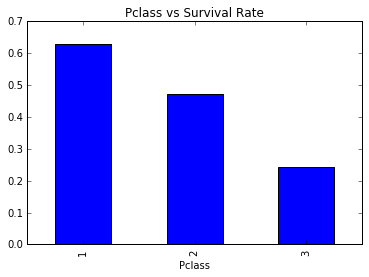

In [11]:
# 利用'Survived'字段值为0/1的特点，直接对该字段求均值，可以得到各等级舱室的幸存率
print(titanic_df.groupby(['Pclass'])['Survived'].mean())


# 画出幸存率对比图
titanic_df.groupby(['Pclass'])['Survived'].mean().plot(kind = 'bar')
plt.title('Pclass vs Survival Rate')
plt.show()

从上述结果来看，头等舱死亡率最低，而三等舱死亡率最高……这仍是一个悲伤的故事~
这不能说明上文所引用的那位[二副回忆录](http://www.360doc.com/content/14/0424/22/1130227_371847207.shtml)里所讲是否都是虚构，但是冰冷的数字告诉我们，在这场人类历史上排得上号的大灾难中，最为凄惨的是那些三等舱里的人们。事实就像电影所描述那样，他们挤在狭小的船舱中，位于巨大船身的中下层，当海水突然袭来，他们生存的机会确实最为渺茫。

我们再来看看，不同性别乘客的幸存情况是怎样：

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


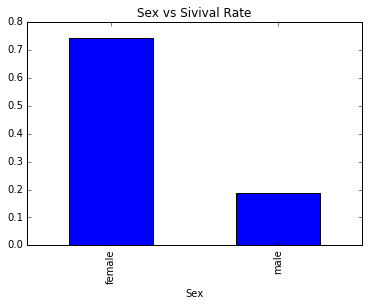

In [12]:
print(titanic_df.groupby(['Sex'])['Survived'].mean())

# 画图
titanic_df.groupby(['Sex'])['Survived'].mean().plot(kind = 'bar')
plt.title('Sex vs Sivival Rate')

我们可以看到：所有乘客中，女性乘客生还率大约74%，而男性乘客只有约19%。

接着我们再从死亡的乘客中，分析其中性别和各等级舱室的组成情况，代码如下所示：

In [20]:
# 首先获取全部死亡记录
death_records = titanic_df[titanic_df['Survived'] == 0]
#print(death_records.info())
#death_records.head()

# 其次得到各船舱等级的死亡性别统计
#death_records.groupby(['Pclass', 'Sex']).count()['PassengerId']

titanic_df.groupby(['Pclass', 'Sex', 'Survived'])['PassengerId'].count()

Pclass  Sex     Survived
1       female  0             3
                1            91
        male    0            77
                1            45
2       female  0             6
                1            70
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: PassengerId, dtype: int64

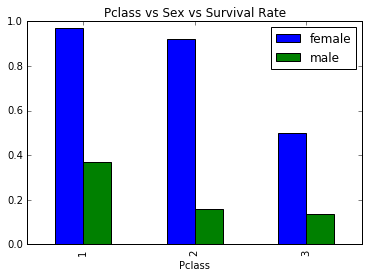

In [21]:
# 画出各等级舱室不同性别乘客幸存比
titanic_df.groupby(['Pclass', 'Sex'])['Survived'].mean().unstack().plot(kind = 'bar')
plt.legend(loc = 'best')
plt.title('Pclass vs Sex vs Survival Rate')

从这份统计中我们看到：头等舱遇难的乘客，绝大部分都是男性，女性乘客只有3位遇难（91位生还）；二等舱也是如此，女性乘客只有6位遇难，其他91位遇难者都是男性；三等舱女性乘客遇难与幸存人数相等（都是72人），男性乘客则有300人遇难，只有47人生还。

In [22]:
# 获取所有男性乘客乘坐舱室等级的分组统计信息
titanic_df[titanic_df['Sex'] == 'male'].groupby('Pclass').count()

,PassengerId,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Pclass,,,,,,,,,,,
1,122,122,122,122,101,122,122,122,122,95,122
2,108,108,108,108,99,108,108,108,108,6,108
3,347,347,347,347,253,347,347,347,347,6,347


In [23]:
def get_male_female_ratio(titanic_df, cl):
    '''
    获取各等级舱室男女比例
    titanic_df：乘客数据
    cl：等级，取值1/2/3
    return：男女比例
    '''
    if cl in [1, 2, 3]:      # 舱室等级只能1，2，3
        male_count = titanic_df[titanic_df['Sex'] == 'male'].groupby('Pclass').count().ix[cl, 0]
        female_count = titanic_df[titanic_df['Sex'] == 'female'].groupby('Pclass').count().ix[cl, 0]
        sex_ratio = male_count / float(female_count)   
        return sex_ratio
    else:
        return -1


tot_class1_sex_ratio = get_male_female_ratio(titanic_df, 1)
tot_class2_sex_ratio = get_male_female_ratio(titanic_df, 2)
tot_class3_sex_ratio = get_male_female_ratio(titanic_df, 3)


print('Class 1 Male / Female ratio:  %f\n') % (tot_class1_sex_ratio)
print('Class 2 Male / Female ratio:  %f\n') % (tot_class2_sex_ratio)
print('Class 3 Male / Female ratio:  %f\n') % (tot_class3_sex_ratio)

Class 1 Male / Female ratio:  1.297872

Class 2 Male / Female ratio:  1.421053

Class 3 Male / Female ratio:  2.409722



([<matplotlib.axis.XTick at 0xa36a2b0>,
 <a list of 3 Text xticklabel objects>)

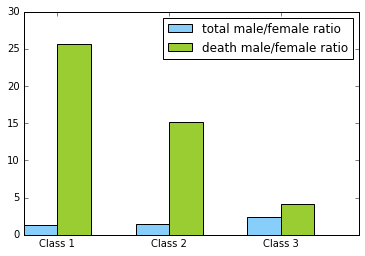

In [37]:
# 获取各等级舱室男女乘客死亡数量
death_class1_male_count = death_records.groupby(['Pclass', 'Sex']).count().ix[1,0].ix[1]
death_class2_male_count = death_records.groupby(['Pclass', 'Sex']).count().ix[2,0].ix[1]
death_class3_male_count = death_records.groupby(['Pclass', 'Sex']).count().ix[3,0].ix[1]

death_class1_female_count = death_records.groupby(['Pclass', 'Sex']).count().ix[1,0].ix[0]
death_class2_female_count = death_records.groupby(['Pclass', 'Sex']).count().ix[2,0].ix[0]
death_class3_female_count = death_records.groupby(['Pclass', 'Sex']).count().ix[3,0].ix[0]

# 各等级舱室死亡性别之比
death_class1_sex_ratio = float(death_class1_male_count) / death_class1_female_count
death_class2_sex_ratio = float(death_class2_male_count) / death_class2_female_count
death_class3_sex_ratio = float(death_class3_male_count) / death_class3_female_count


# 画出全船各等级舱室乘客性别之比：

plt.bar(0,tot_class1_sex_ratio, width = 0.3, facecolor= 'lightskyblue' )
plt.bar(0.3,death_class1_sex_ratio, width = 0.3, facecolor = 'yellowgreen' )
    
plt.bar(1,tot_class2_sex_ratio, width = 0.3, facecolor= 'lightskyblue' )
plt.bar(1.3,death_class2_sex_ratio, width = 0.3, facecolor = 'yellowgreen' )
    
plt.bar(2,tot_class3_sex_ratio, width = 0.3, facecolor= 'lightskyblue' )
plt.bar(2.3,death_class3_sex_ratio, width = 0.3, facecolor = 'yellowgreen' )

plt.legend(['total male/female ratio', 'death male/female ratio'], loc = 'best')
plt.xticks([0.3, 1.3, 2.3],('Class 1', 'Class 2', 'Class 3',),fontsize = 10)


可以从对比中看到：对于一等舱和二等舱，男女乘客有一个较为常规的比例，但是死亡的却大部分是男性；对三等舱，死者性别男女比例也要大于三等舱全部乘客的男女之比。这表明，泰坦尼克号上的所有男性乘客，不论贵贱，都表现得十分英勇；而高等舱的男性乘客们，以自己的生命为代价，让身边绝大多数女性乘客得以生还，更是可歌可泣！

### 3) 问题3:地域特征

最后我们关注从不同港口登船的乘客信息，需要留意到的是'Embarked'字段略有缺失，有2位乘客的信息不详。

Embarked  Pclass
C         1          85
          2          17
          3          66
Q         1           2
          2           3
          3          72
S         1         127
          2         164
          3         353
Name: PassengerId, dtype: int64


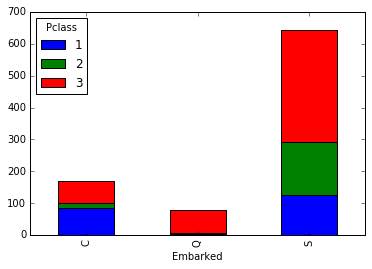

In [40]:
print(titanic_df.groupby(['Embarked', 'Pclass'])['PassengerId'].count())
titanic_df.groupby(['Embarked', 'Pclass'])['PassengerId'].count().unstack().plot(kind = 'bar', stacked = 'True')

可以看出来，C港口（Cherbourg）上船的乘客头等舱人数占比最高，甚至高过三等舱人数；Q（Queenstown）港口乘客绝大多数分布在三等舱，头等舱与二等舱人数寥寥无几；S（Southampton）港口登船总人数最多，比例也最符合常理，即等级越低，人数占比越大。因此我们简单猜测：Cherbourg或许是个富人较多的城市，但是人数不是很多；Queenstown相对最穷，乘船人少，买得起的也基本都是三等舱；Southampton应该是一个人口很多的大城市。

## 3.结论

至此，我们探索了整个数据，提出了一些问题，发现了一些线索，并找出了一些答案。必须强调的是：**所有分析结论都是基于该数据文件所得到的**，如果有更完整更可靠的数据，部分结论可能有所不同。

### 1）数据并非完整可靠的数据

该文件只包含了**部分**乘客的信息，而不是全部，同时各个乘客的信息并不全部完善，更重要的是，有部分字段信息怀疑有误。

### 2) 乘客舱室等级信息看似有误，分析后发现较为合理

从数据直接给出的统计结果看，三等舱人数 > 头等舱人数 > 二等舱人数，这与一般常识不符。除去样本数据不全之外，还发现各舱室票价存在少部分0值。除开这两个因素，剩下的数据没有发现明显异常，即通过数据认定，实际乘客分布就是如此。通过网络其他渠道信息证实了这一观点。

### 3) 男性乘客表现英勇

从统计来看，所有舱室的男性乘客死亡比例都大于女性乘客，高等级舱室尤其如此。二副的回忆录中所讲似乎是一个说得过去的解释，如果真是如此，也许世界欠他们一个道歉。

### 4）不同城市，贫富悬殊各自不同

对三个不同港口登船乘客舱室等级的比较，发现富裕地区和欠发达地区乘客选择舱室差别很大。

-------

### 参考：

#### 1.《Python数据科学指南》—— 人民邮电出版社

#### 2.《利用Python进行数据分析》—— 机械工业出版社